# **Problem Statement**

Forecast the CocaCola prices data set. Prepare a document for each model explaining
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for
Forecasting.

In [18]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import calendar
from math import sqrt
from pandas import datetime
import plotly.express as px
from scipy.stats import boxcox
import plotly.graph_objects as go
from pandas.plotting import lag_plot
import statsmodels.formula.api as smf
from plotly.subplots import make_subplots
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
from google.colab import files
uploaded=files.upload()

Saving CocaCola_Sales_Rawdata.xlsx to CocaCola_Sales_Rawdata (1).xlsx


In [21]:
cocacola_df=pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
cocacola_df

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [22]:
cocacola_df.shape

(42, 2)

# **EDA**

In [ ]:
cocacola_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [ ]:
cocacola_df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [ ]:
# checking for duplicated rows
cocacola_df[cocacola_df.duplicated()]

,Quarter,Sales


# **Feature Engineering**

In [23]:
#Converting the Quarters into Years
cocacola_df['Quarter_Year'] = cocacola_df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
cocacola_df.head(10)

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


In [24]:
#Coverting Quarter Years with Quarter Start Date Year (Date Month and Year)
cocacola_df['Date'] = (pd.to_datetime(cocacola_df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))
cocacola_df.head(10)

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


In [25]:
#Extracting the Quarters and putting in column
cocacola_df['Quarters'] = 0

for i in range(42):
    n = cocacola_df['Quarter'][i]
    cocacola_df['Quarters'][i] = n[0:2]

cocacola_df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2


In [26]:
# Creating Dummy Variables for Quarters Variable
dummy = pd.DataFrame(pd.get_dummies(cocacola_df['Quarters']))
data = pd.concat((cocacola_df, dummy), axis=1)

data.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0


In [28]:
data["Date"] = pd.to_datetime(data.Date,format="%b-%y")
data["month"] = data.Date.dt.strftime("%b") # month extraction
data["year"] = data.Date.dt.strftime("%Y") # year extraction

In [29]:
data.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0,Jan,1987
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2,0,1,0,0,Apr,1987
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3,0,0,1,0,Jul,1987
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4,0,0,0,1,Oct,1987
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1,1,0,0,0,Jan,1988
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2,0,1,0,0,Apr,1988


# **Data Visualization**

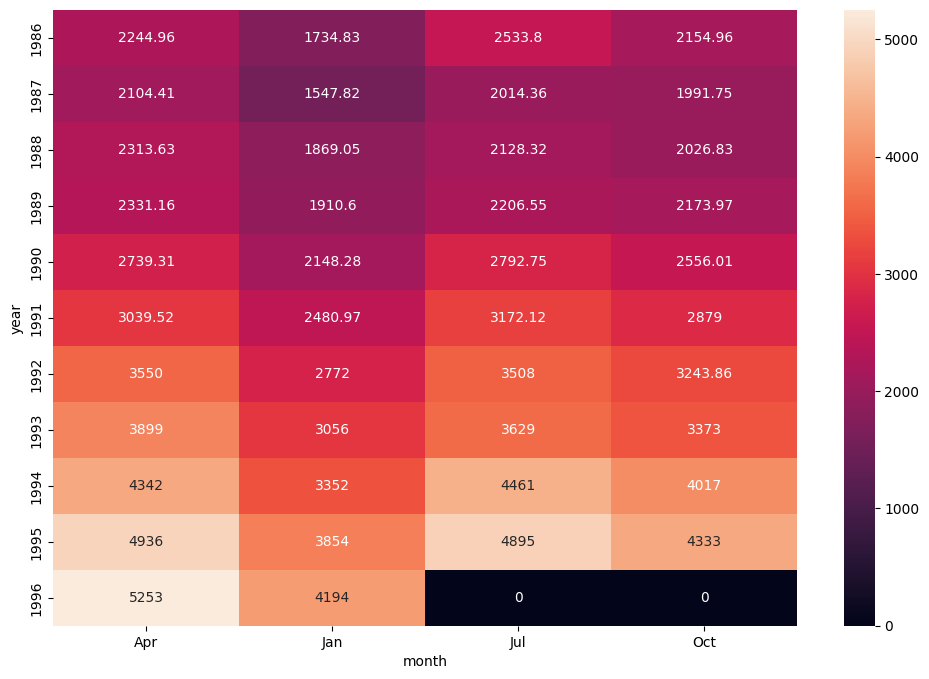

In [30]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=data, values="Sales", index="year", columns="month", aggfunc="mean", fill_value=0)
sns.heatmap(heatmap_y_month, annot=True, fmt="g")
plt.show()

# Line plot

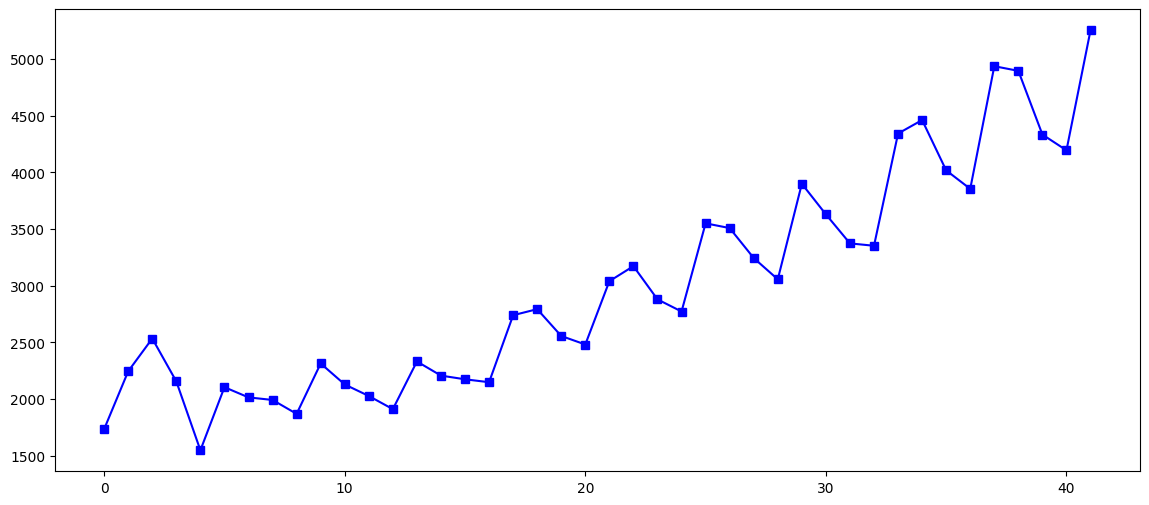

In [35]:
data["Sales"].plot(figsize=(14,6), color='blue', marker='s')
plt.show()

# Histogram and Density Plots

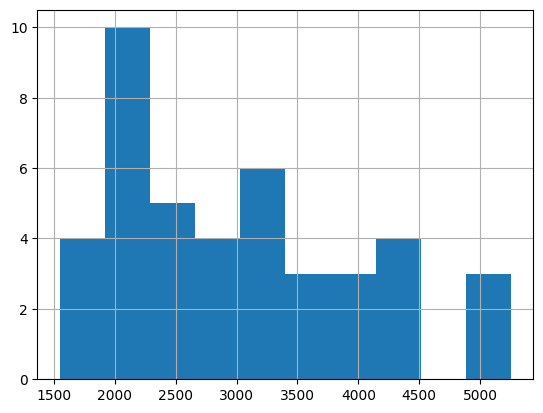

In [34]:
data["Sales"].hist()
plt.show()

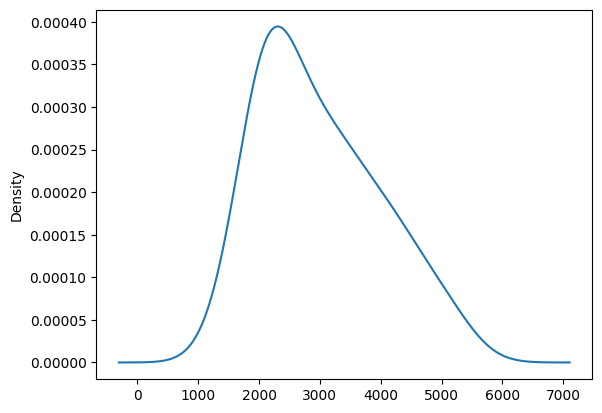

In [36]:
data["Sales"].plot(kind='kde')
plt.show()

# Lag plot

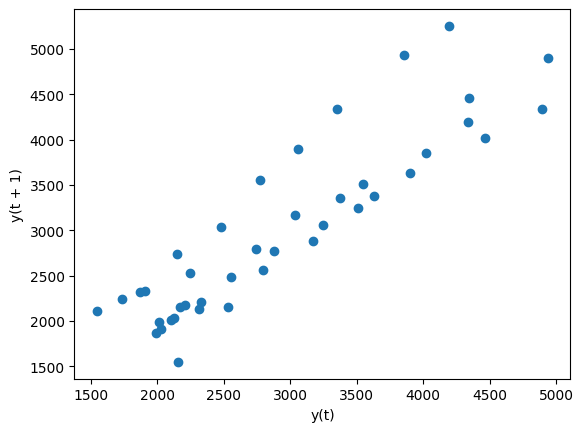

In [40]:
# create a scatter plot
lag_plot(data.Sales)
plt.show()

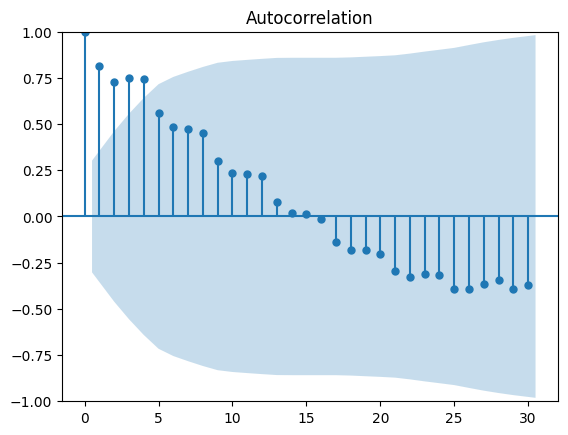

In [41]:
# create an autocorrelation plot
plot_acf(data.Sales,lags=30)
plt.show()

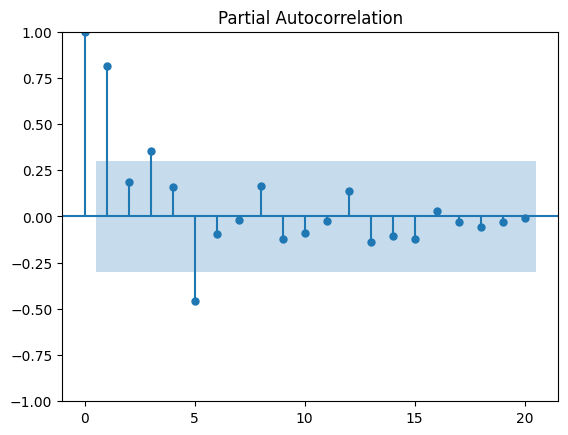

In [42]:
# create an Partial Autocorrelation
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_pacf(data.Sales,lags=20)
plt.show()

# **Sampling**

# Upsampling Data

In [45]:
cocacola_df['Date'] = pd.to_datetime(cocacola_df['Date'])

In [46]:
cocacola_df.set_index('Date', inplace=True)

In [47]:
upsampled_month = cocacola_df.drop(['Quarter_Year','Quarters','Quarter'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(10))

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330
1987-01-31  1547.818996


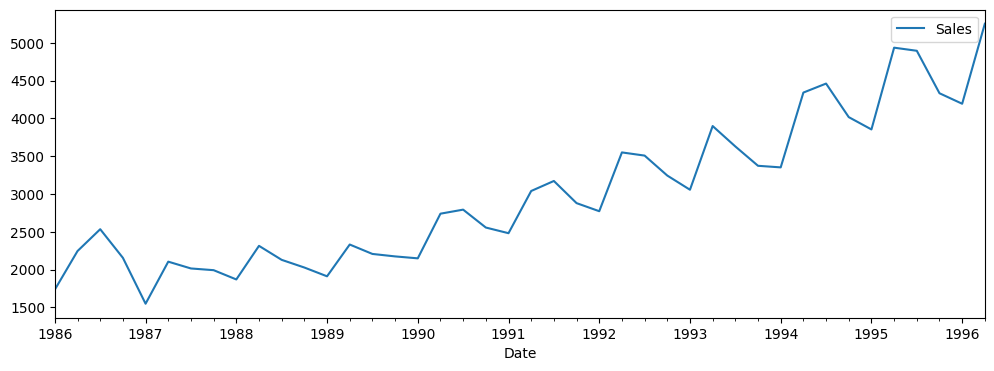

In [48]:
interpolated_month = upsampled_month.interpolate(method='linear')
print(interpolated_month.head(13))
interpolated_month.plot(figsize=(12,4))
plt.show()

In [49]:
interpolated_month

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


# Downsampling Data

In [51]:
resample = interpolated_month.resample('Q')
quarterly_mean_sales = resample.mean()

In [52]:
quarterly_mean_sales

,Sales
Date,
1986-03-31,1904.871666
1986-06-30,2341.242330
1986-09-30,2407.524328
1986-12-31,1952.581664
1987-03-31,1733.349996
1987-06-30,2074.395663
1987-09-30,2006.824332
1987-12-31,1950.847998
1988-03-31,2017.243998


# **Splitting Train and Test Data**

In [53]:
train_data = interpolated_month[:100]
test_data = interpolated_month[100:]

In [54]:
print('Train :',train_data.index.min(),train_data.index.max(),'\n',
'Test :',test_data.index.min(),test_data.index.max())

Train : 1986-01-31 00:00:00 1994-04-30 00:00:00 
 Test : 1994-05-31 00:00:00 1996-04-30 00:00:00


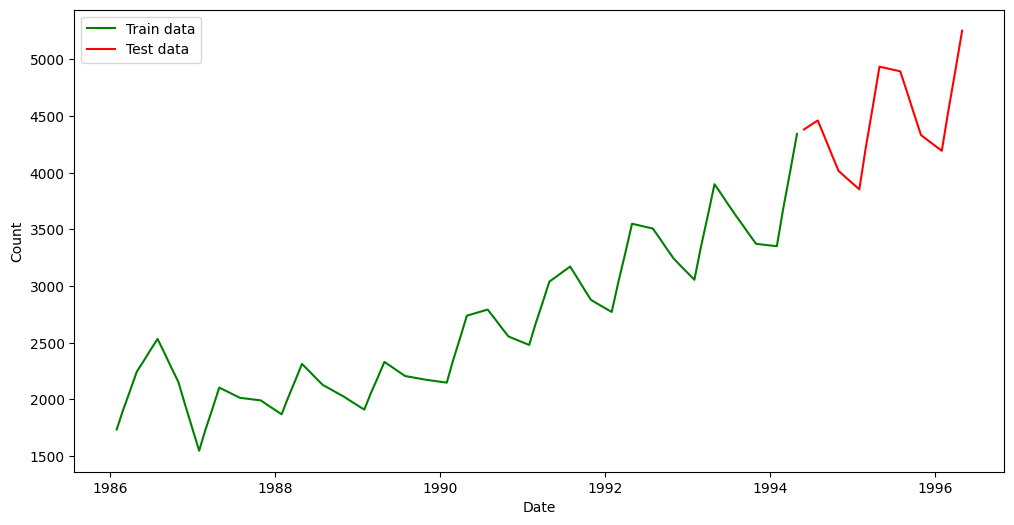

In [55]:
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()
plt.show()

# Evaluation Metric MAPE

In [56]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# **Exponential Methods**

# Simple Exponential Method

In [62]:
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)

In [63]:
test_rmse_ses

381.95422355078995

In [64]:
train_rmse_ses

129.37951431349904

#Holt method

In [66]:
hw_model = Holt(train_data['Sales']).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test_data.index[0],end = test_data.index[-1])
MAPE(pred_hw,test_data['Sales'])

36.224347151569425

# Holts winter exponential smoothing with additive seasonality and additive trend

In [68]:
hwe_model_add_add = ExponentialSmoothing(train_data['Sales'],seasonal="add",trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test_data.index[0],end = test_data.index[-1])
MAPE(pred_hwe_add_add,test_data['Sales'])

35.69571274324909

# Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [69]:
hwe_model_mul_add = ExponentialSmoothing(train_data['Sales'],seasonal="mul",trend="add",seasonal_periods=12).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test_data.index[0],end = test_data.index[-1])
MAPE(pred_hwe_mul_add,test_data.Sales)

1.487268775553493

# **Feature Scaling (Transformations)**

# 1. Square Root Transform

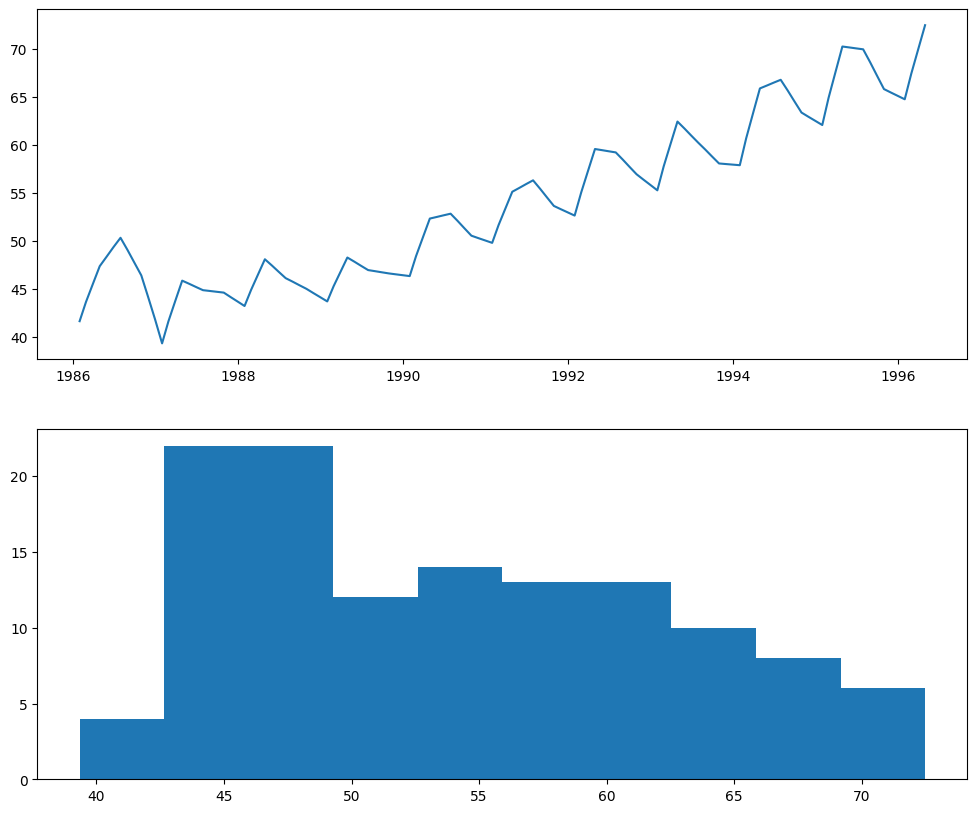

In [70]:
square_root = pd.DataFrame()
square_root = interpolated_month[['Sales']]
square_root['Sales'] = np.sqrt(square_root.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Sales'])

# Histogram
plt.subplot(212)
plt.hist(square_root['Sales'])
plt.show()

# 2. Log Transform

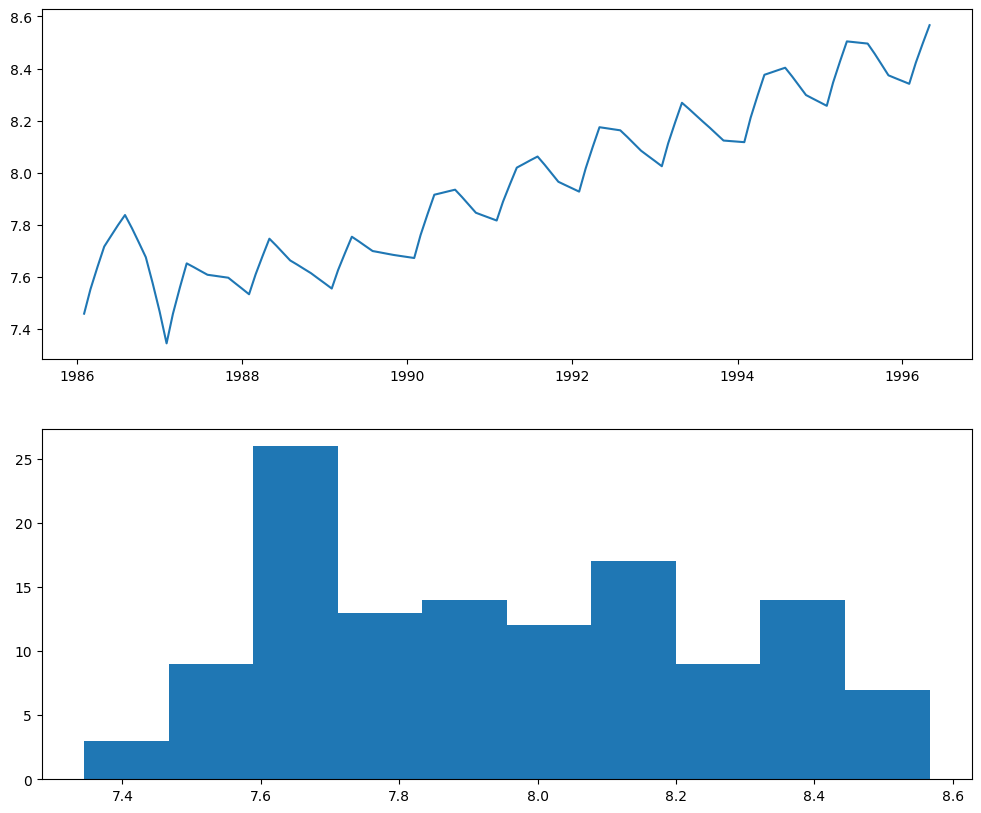

In [71]:
log = pd.DataFrame()
log = interpolated_month[['Sales']]
log['Sales'] = np.log(log.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Sales'])

# Histogram
plt.subplot(212)
plt.hist(log['Sales'])
plt.show()

# 3)Box Cox Transformation

,Sales
Date,
1986-01-31,7.458663
1986-02-28,7.552170
1986-03-31,7.637676
1986-04-30,7.716443
1986-05-31,7.758437


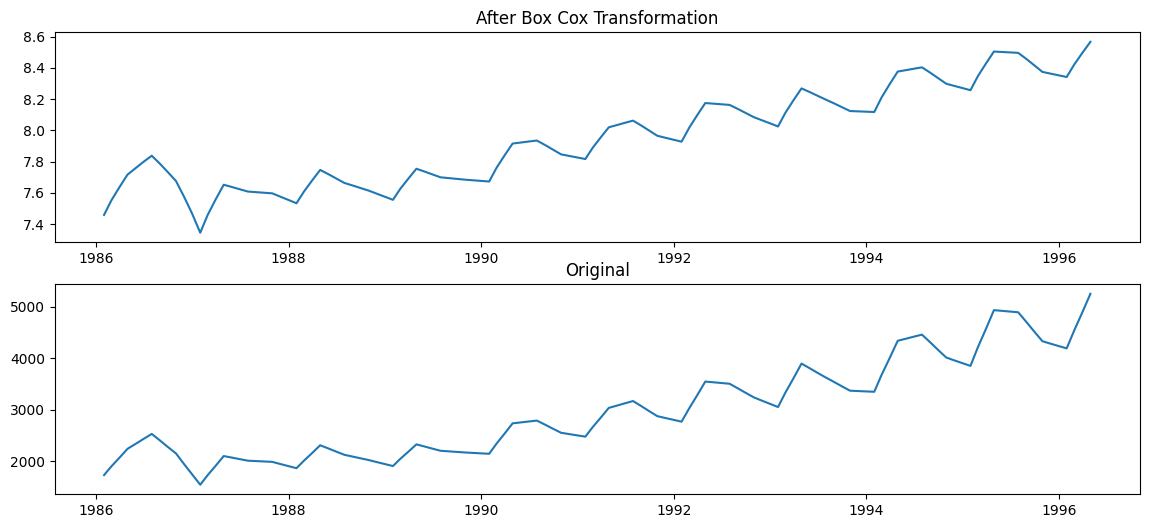

In [72]:
data_boxcox = pd.DataFrame()
data_boxcox['Sales'] = pd.Series(boxcox(interpolated_month['Sales'], lmbda=0), interpolated_month.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(interpolated_month, label='original')
axis[1].set_title('Original')
plt.show()

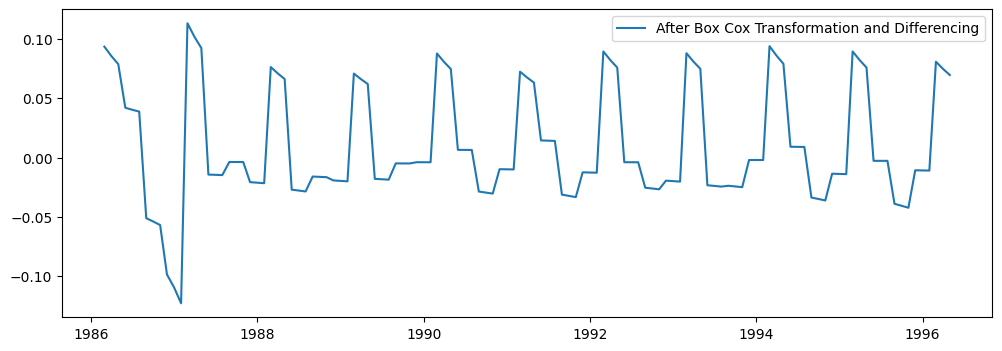

In [74]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

# **Building The Time Series Forecasting with Optimal Value using ARIMA**

In [75]:
train_data_boxcox = data_boxcox[:100]
test_data_boxcox = data_boxcox[100:]
train_data_boxcox_diff = data_boxcox_diff[:99]
test_data_boxcox_diff = data_boxcox_diff[99:]

In [77]:
def evaluate_arima_model(X, arima_order):
# Prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

# Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

# Calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [78]:
# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [79]:
p_values = range(0,5)
d_values = range(0,5)
q_values = range(0,5)
evaluate_models(train_data_boxcox_diff.Sales, p_values, d_values, q_values)

Best ARIMA(3, 0, 2) RMSE=0.028


In [80]:
#Inverse transformation of the Box-Cox Differencing
model = ARIMA(train_data_boxcox_diff, order=(3, 0, 2))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())

# For that we are using cumsum() method
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()

y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Sales[0])
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

# **Model Evaluation**

# RMSE

In [81]:
rmse_arima = np.sqrt(mean_squared_error(test_data.Sales, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_arima

455.39

# MAPE

In [82]:
mape_arima = round(np.mean(np.abs((test_data.Sales - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.Sales)*100),2)
mape_arima

8.57

# **Data Pre-processing for Model Driven Techniques**

In [83]:
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.Date.dt.strftime("%b") # month extraction
interpolated_month["year"] = interpolated_month.Date.dt.strftime("%Y") # year extraction

In [84]:
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([interpolated_month,months],axis=1)
cocacola['log_sales'] = np.log(cocacola['Sales'])
cocacola

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
120,1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
121,1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223
122,1996-03-31,4900.000000,123,15129,Mar,1996,0,0,1,0,0,0,0,0,0,0,0,0,8.496990


In [85]:
train_data = cocacola.iloc[:100]
test_data = cocacola.iloc[100:]

# **Building Ordinary Square Model**

# Linear Model

In [86]:
linear_model = smf.ols('Sales~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_linear))**2))
rmse_linear

686.8740863668942

# Exponential Model

In [87]:
exp = smf.ols('log_sales~t',data=train_data).fit()
pred_exp = pd.Series(exp.predict(pd.DataFrame(test_data['t'])))
rmse_exp = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_exp)))**2))
rmse_exp

530.326802509923

# Quadratic Mode

In [88]:
quad = smf.ols('Sales~t+t_squared',data=train_data).fit()
pred_quad = pd.Series(quad.predict(test_data[["t","t_squared"]]))
rmse_quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_quad))**2))
rmse_quad

371.29418344986675

# Additive seasonality

In [89]:
add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1837.7879723483793

# Multiplicative Seasonality

In [90]:
mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_sea = pd.Series(mul_sea.predict(test_data))
rmse_mult_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_mult_sea)))**2))
rmse_mult_sea

1904.7944171920315

Simple Exponential Method with Multiplicative Seasonality and Additive Trend is the best model